In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as ns
import xml.etree.ElementTree as ET
import time
import re

## Reding xml data into pandas dataframe

In [2]:
def read_xml(xml_filename):
    xtree = ET.parse(xml_filename)
    xroot = xtree.getroot() 
    
    # getting the columns
    df_cols = []
    for x in xroot:
        for attr in x.attrib:
            if attr not in df_cols:
                df_cols.append(attr)
    
    # getting the records
    rows = []
    for x in xroot:
        row = dict()
        for col in df_cols:
            if col in x.attrib:
                row[col] = x.attrib[col]
            else:
                row[col] = None
        rows.append(row)
        
    out_df = pd.DataFrame(rows, columns = df_cols)
    return out_df

In [3]:
%%time
badges = read_xml("data/Badges.xml")
print("badges:", badges.shape)
comments = read_xml("data/Comments.xml")
print("comments:", comments.shape)
post_history = read_xml("data/PostHistory.xml")
print("post_history:", post_history.shape)
post_links = read_xml("data/PostLinks.xml")
print("post_links:", post_links.shape)
posts = read_xml("data/Posts.xml")
print("posts:", posts.shape)
tags = read_xml("data/Tags.xml")
print("tags:", tags.shape)
users = read_xml("data/Users.xml")
print("users:", users.shape)
votes = read_xml("data/Votes.xml")
print("votes:", votes.shape)

badges: (78180, 6)
comments: (41722, 7)
post_history: (121522, 9)
post_links: (1653, 5)
posts: (39929, 21)
tags: (489, 5)
users: (66951, 13)
votes: (125650, 6)
Wall time: 5.6 s


In [4]:
start_time = time.time()

## Generating insights

### 1. Working with the tags table

In [5]:
tags.head()

,Id,TagName,Count,ExcerptPostId,WikiPostId
0,1,definitions,26,105,104
1,2,machine-learning,6024,4909,4908
2,3,bigdata,390,66,65
3,5,data-mining,865,80,79
4,6,databases,70,8960,8959


In [6]:
tags['Count'] = tags['Count'].astype(int)
tags = tags.sort_values(by='Count', ascending=False)
top10tags = tags.head(10)
top10tags

,Id,TagName,Count,ExcerptPostId,WikiPostId
1,2,machine-learning,6024,4909,4908
31,46,python,3323,5523,5522
55,81,neural-network,2570,8885,8884
108,194,deep-learning,2405,8956,8955
52,77,classification,1653,4911,4910
189,324,keras,1426,9251,9250
81,128,scikit-learn,1119,5896,5895
18,24,r,1027,49,48
186,321,tensorflow,1024,9183,9182
32,47,nlp,981,147,146


- most used tags in stackoverflow
- what is the trend of python and r over the years?

### 2. Working with the Posts table

In [7]:
posts['CreationDate'] = pd.to_datetime(posts['CreationDate'], format="%Y-%m-%dT%H:%M:%S")
posts['CreationYear'] = posts['CreationDate'].dt.year
posts.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,FavoriteCount,ClosedDate,AcceptedAnswerId,LastEditorUserId,LastEditDate,ParentId,CommunityOwnedDate,LastEditorDisplayName,OwnerDisplayName,CreationYear
0,5,1,2014-05-13 23:58:30.457,8,604,<p>I've always been interested in machine lear...,5,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,...,1,2014-05-14T14:40:25.950,None,None,None,None,None,None,None,2014
1,7,1,2014-05-14 00:11:06.457,4,426,"<p>As a researcher and instructor, I'm looking...",36,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,...,1,2014-05-14T08:40:54.950,10,97,2014-05-16T13:45:00.237,None,None,None,None,2014
2,9,2,2014-05-14 00:36:31.077,5,None,"<p>Not sure if this fits the scope of this SE,...",51,2014-05-14T00:36:31.077,None,None,...,None,None,None,None,None,5,None,None,None,2014
3,10,2,2014-05-14 00:53:43.273,12,None,"<p>One book that's freely available is ""The El...",22,2014-05-14T00:53:43.273,None,None,...,None,None,None,None,None,7,None,None,None,2014
4,14,1,2014-05-14 01:25:59.677,23,1495,<p>I am sure data science as will be discussed...,66,2014-06-20T17:36:05.023,Is Data Science the Same as Data Mining?,<data-mining><definitions>,...,6,None,29,322,2014-06-17T16:17:20.473,None,None,None,None,2014


In [8]:
yearTags = posts[['CreationYear', 'Tags']]
print(yearTags.shape)
yearTags = yearTags.dropna() # removing rows that has null tags
print(yearTags.shape)
yearTags.Tags = yearTags.Tags.str.replace('<', '').str.replace('>', ' ').str.split()
yearTags.head()

(39929, 2)
(18513, 2)


,CreationYear,Tags
0,2014,[machine-learning]
1,2014,"[education, open-source]"
4,2014,"[data-mining, definitions]"
5,2014,[databases]
6,2014,"[machine-learning, bigdata, libsvm]"


#### Show the top 5 used tags in each year

In [9]:
%%time
popularTagsInYear = dict()

for index, row in yearTags.iterrows():
    if row['CreationYear'] not in popularTagsInYear:
        popularTagsInYear[row['CreationYear']] = dict()
    curDict = popularTagsInYear[row['CreationYear']]
    for tag in row['Tags']:
            if tag not in curDict:
                curDict[tag] = 0
            curDict[tag] += 1

Wall time: 1.55 s


In [10]:
rows_list = []
for yearItem in popularTagsInYear.items():
    for key, value in sorted(yearItem[1].items(), key=lambda item: item[1], reverse=True)[:5]:
        rows_list.append([yearItem[0], key, value])
        #print("%s: %s" % (key, value))
popularTagsInYearDf = pd.DataFrame(rows_list, columns=['year','tag','count'])
popularTagsInYearDf.head()

,year,tag,count
0,2014,machine-learning,171
1,2014,data-mining,74
2,2014,classification,73
3,2014,bigdata,61
4,2014,r,54


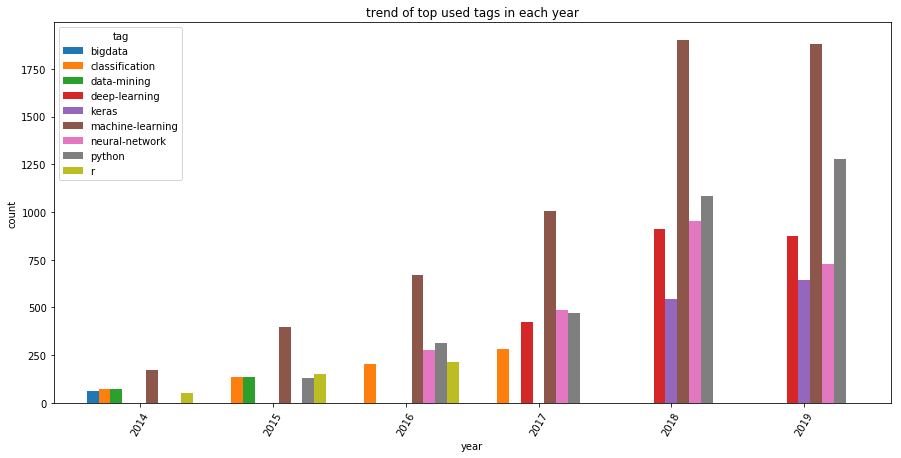

In [11]:
popularTagsInYearDf.pivot("year", "tag", "count").plot(kind='bar', figsize=(15, 7), width=0.8, rot=60) # stacked=True
plt.title("trend of top used tags in each year")
plt.ylabel('count')
plt.show()

- as we can see popularity of machine-learning and python are increasing over the years
- if we think about python and r as programming language, we see that till 2015 r was the popular one but after 2016 python getting more popular
- neural-network was getting popular till 2018, although we see a drop in the recent year
- we can also observe that keras and deep-learning becoming more popular

#### what is the trend of top used tags (i.e. python vs r) over the years?

In [12]:
rows_list = []
for yearItem in popularTagsInYear.items():
    curDict = yearItem[1]
    arrCount = [0]*(top10tags.shape[0]+1)
    arrCount[0] = yearItem[0]
    ind = 1
    for x in top10tags['TagName']:
        if x in curDict:
            arrCount[ind] = curDict[x]
        ind += 1
    rows_list.append(arrCount)
# print(row_list)
columns = ['year']
for x in top10tags['TagName']:
    columns.append(x)
trendDf = pd.DataFrame(rows_list, columns=columns)
trendDf

,year,machine-learning,python,neural-network,deep-learning,classification,keras,scikit-learn,r,tensorflow,nlp
0,2014,171,43,26,8,73,0,14,54,0,40
1,2015,398,130,96,30,133,2,43,153,4,56
2,2016,670,315,279,157,206,60,148,212,70,117
3,2017,1005,472,485,425,283,174,183,209,172,170
4,2018,1899,1083,955,909,493,546,358,204,377,268
5,2019,1881,1280,729,876,465,644,373,195,401,330


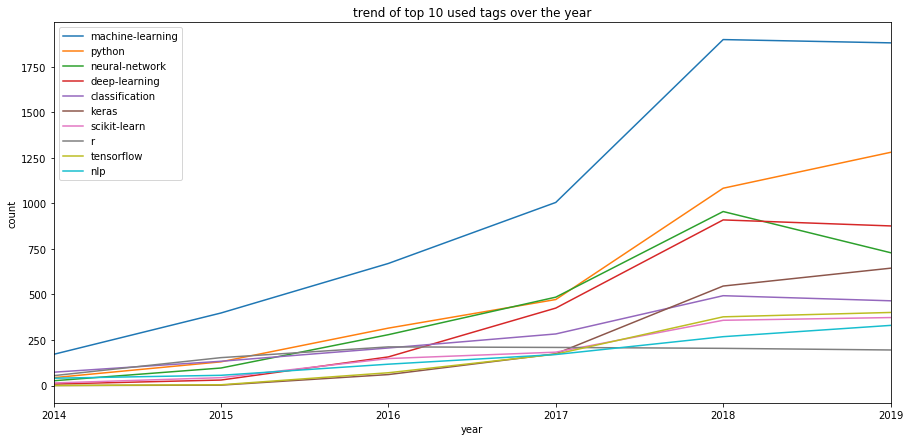

In [13]:
trendDf.plot(x='year', figsize=(15, 7))
plt.title("trend of top 10 used tags over the year")
plt.ylabel("count")
plt.xticks(np.arange(2014, 2020, step=1))
plt.show()

### Graph Representation

In [14]:
# implementation of an undirected graph using Adjacency Lists
class Vertex:
    def __init__(self, name):
        self.name = name
        self.neighbors = list()
    
    def add_neighbor(self, v):
        if v not in self.neighbors:
            self.neighbors.append(v)

class Graph:
    def __init__(self):
        self.vertices = {}
    
    def add_vertex(self, vertex):
        if isinstance(vertex, Vertex) and vertex.name not in self.vertices:
            self.vertices[vertex.name] = vertex
            return True
        else:
            return False
    
    def add_edge(self, u, v):
        if u in self.vertices and v not in self.vertices[u].neighbors: # removing duplicate edges
            self.vertices[u].add_neighbor(v)
            return True
        else:
            return False
    
    def sort_neighbors(self):
        for x in self.vertices:
            self.vertices[x].neighbors.sort()
            
    def print_graph(self):
        for key in self.vertices.keys():
            print(str(key) + str(self.vertices[key].neighbors))

In [15]:
print("It took %s seconds to process" % (time.time() - start_time))

It took 2.274376392364502 seconds to process
